# Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_DIR = "/Users/elbethelzewdie/Downloads/ethiopia-fi-forecast/ethiopia-fi-forecast/data/raw"

data_path = f"{DATA_DIR}/ethiopia_fi_unified_new.csv"
impact_links_path = f"{DATA_DIR}/impact_sheet_new.csv"
reference_codes_path = f"{DATA_DIR}/reference_codes.csv"


In [3]:
data = pd.read_csv(data_path)

### 1. Dataset Overview

#### 1.1 Summarize by record_type, pillar, source_type

In [4]:
# Record type distribution
record_type_summary = data["record_type"].value_counts()
record_type_summary

record_type
observation    49
event          14
target          3
Name: count, dtype: int64

In [5]:
# Pillar distribution
pillar_summary = data["pillar"].value_counts(dropna=False)
pillar_summary


pillar
ACCESS           25
USAGE            21
NaN              14
GENDER            5
AFFORDABILITY     1
Name: count, dtype: int64

In [6]:
# Source type distribution
source_type_summary = data["source_type"].value_counts(dropna=False)
source_type_summary


source_type
operator                            20
survey                              19
regulator                            7
research                             4
https://www.worldbank.org/findex     4
NaN                                  4
policy                               3
calculated                           2
news                                 2
administrative                       1
Name: count, dtype: int64

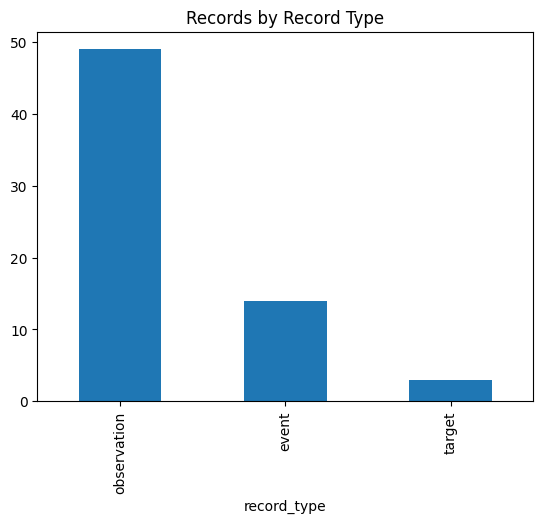

In [7]:
record_type_summary.plot(kind="bar", title="Records by Record Type")
plt.show()

### 2. Temporal Coverage Analysis

#### 2.1 Extract year safely

In [8]:
data["year"] = pd.to_datetime(
    data["observation_date"], errors="coerce"
).dt.year

# fallback to period_end if observation_date is missing
mask = data["year"].isna()
data.loc[mask, "year"] = pd.to_datetime(
    data.loc[mask, "period_end"], errors="coerce"
).dt.year

/var/folders/7h/pt6smvdj6k993z68shptnrdc0000gn/T/ipykernel_8182/935175122.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data.loc[mask, "year"] = pd.to_datetime(


In [9]:
data["year"].describe()

count      62.000000
mean     2023.064516
std         3.328323
min      2012.000000
25%      2023.250000
50%      2024.000000
75%      2025.000000
max      2030.000000
Name: year, dtype: float64

#### 2.2 Coverage: which indicators have data in which years

In [10]:
coverage = (
    data[data["record_type"] == "observation"]
    .dropna(subset=["indicator_code", "year"])
    .groupby(["indicator_code", "year"])
    .size()
    .unstack(fill_value=0)
)


In [11]:
coverage.shape
coverage.head()

year,2012.0,2014.0,2017.0,2021.0,2023.0,2024.0,2025.0
indicator_code,,,,,,,
ACC_4G_COV,0,0,0,0,1,0,1
ACC_ATM_DENSITY,0,0,0,0,0,1,0
ACC_BRANCH_DENSITY,0,0,0,0,0,1,0
ACC_DIGITAL_ID_SHARE,0,0,0,0,0,0,1
ACC_FAYDA,0,0,0,0,0,1,2


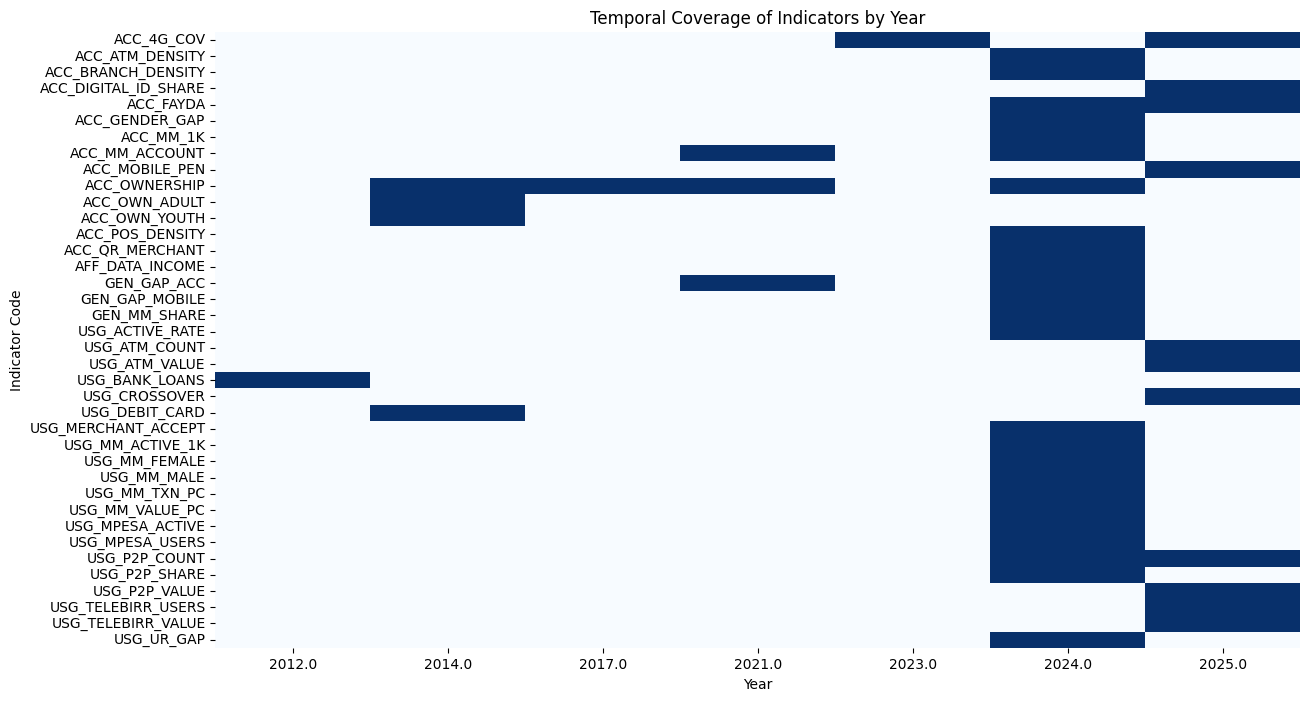

In [12]:
plt.figure(figsize=(14, 8))
sns.heatmap(
    coverage.astype(bool),
    cmap="Blues",
    cbar=False
)
plt.title("Temporal Coverage of Indicators by Year")
plt.xlabel("Year")
plt.ylabel("Indicator Code")
plt.show()

### 3. Data Quality Assessment

#### 3.1 Confidence distribution

In [13]:
data["confidence"].value_counts(dropna=False)

confidence
high      45
medium    13
NaN        8
Name: count, dtype: int64

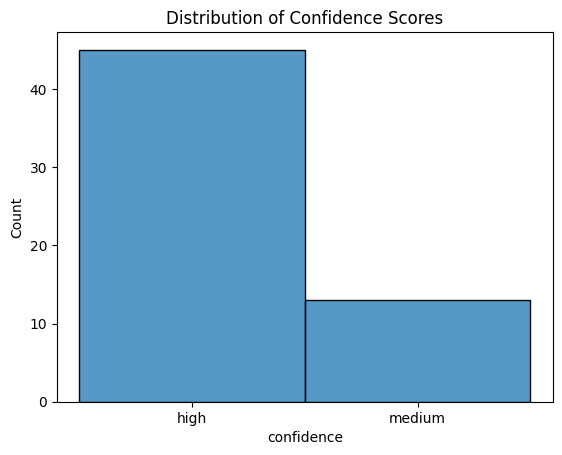

In [14]:
sns.histplot(data["confidence"].dropna(), bins=10)
plt.title("Distribution of Confidence Scores")
plt.show()


### 4. Identify Sparse Indicators

In [15]:
indicator_counts = (
    data[data["record_type"] == "observation"]
    .dropna(subset=["indicator_code", "year"])
    .groupby("indicator_code")["year"]
    .nunique()
    .sort_values()
)

In [16]:
sparse_indicators = indicator_counts[indicator_counts < 3]
sparse_indicators


indicator_code
USG_ACTIVE_RATE         1
USG_ATM_VALUE           1
USG_BANK_LOANS          1
USG_CROSSOVER           1
USG_DEBIT_CARD          1
USG_MERCHANT_ACCEPT     1
USG_MM_ACTIVE_1K        1
USG_MM_FEMALE           1
USG_MM_MALE             1
USG_MM_TXN_PC           1
USG_MM_VALUE_PC         1
USG_MPESA_ACTIVE        1
USG_MPESA_USERS         1
USG_P2P_SHARE           1
USG_P2P_VALUE           1
USG_TELEBIRR_USERS      1
USG_ATM_COUNT           1
USG_TELEBIRR_VALUE      1
USG_UR_GAP              1
GEN_GAP_MOBILE          1
ACC_ATM_DENSITY         1
AFF_DATA_INCOME         1
ACC_QR_MERCHANT         1
ACC_POS_DENSITY         1
ACC_OWN_YOUTH           1
ACC_OWN_ADULT           1
ACC_BRANCH_DENSITY      1
ACC_MOBILE_PEN          1
GEN_MM_SHARE            1
ACC_MM_1K               1
ACC_GENDER_GAP          1
ACC_DIGITAL_ID_SHARE    1
ACC_MM_ACCOUNT          2
ACC_FAYDA               2
GEN_GAP_ACC             2
USG_P2P_COUNT           2
ACC_4G_COV              2
Name: year, dtype: int6

### 5. Account Ownership Trajectory (2011–2024)

#### 5.1 Filter account ownership indicator

In [17]:
account_ownership = data[
    (data["record_type"] == "observation")
    & (data["indicator_code"].str.contains("ACC_OWNERSHIP", na=False))
].sort_values("year")


#### 5.2 Plot trajectory

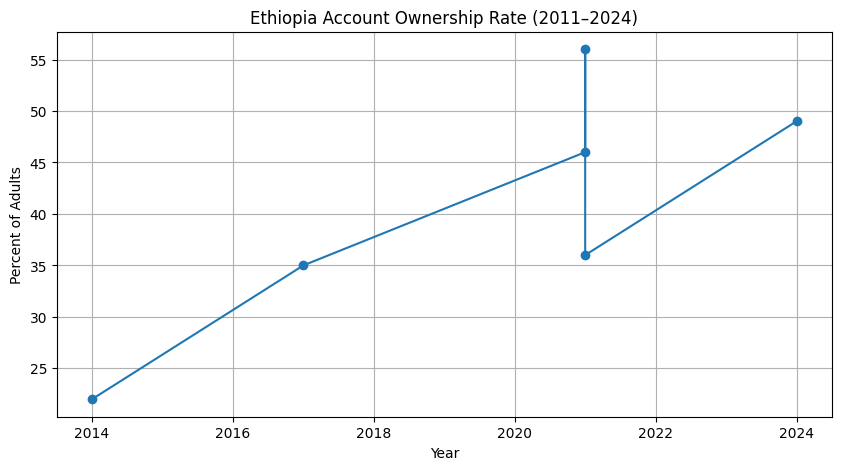

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(account_ownership["year"], account_ownership["value_numeric"], marker="o")
plt.title("Ethiopia Account Ownership Rate (2011–2024)")
plt.ylabel("Percent of Adults")
plt.xlabel("Year")
plt.grid(True)
plt.show()


### 6. Growth Rates Between Survey Years

In [19]:
account_ownership["growth_pp"] = account_ownership["value_numeric"].diff()

account_ownership[["year", "value_numeric", "growth_pp"]]

,year,value_numeric,growth_pp
0,2014.0,22.0,NaN
1,2017.0,35.0,13.0
2,2021.0,46.0,11.0
3,2021.0,56.0,10.0
4,2021.0,36.0,-20.0
5,2024.0,49.0,13.0


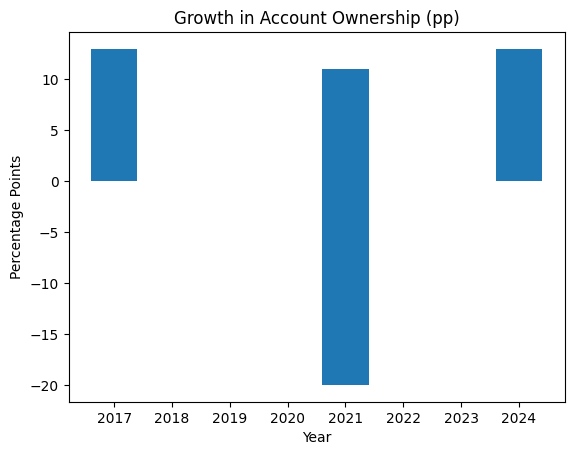

In [20]:
plt.bar(account_ownership["year"], account_ownership["growth_pp"])
plt.title("Growth in Account Ownership (pp)")
plt.ylabel("Percentage Points")
plt.xlabel("Year")
plt.show()


### 7. Disaggregated Analysis (If Available)

#### 7.1 Gender gap

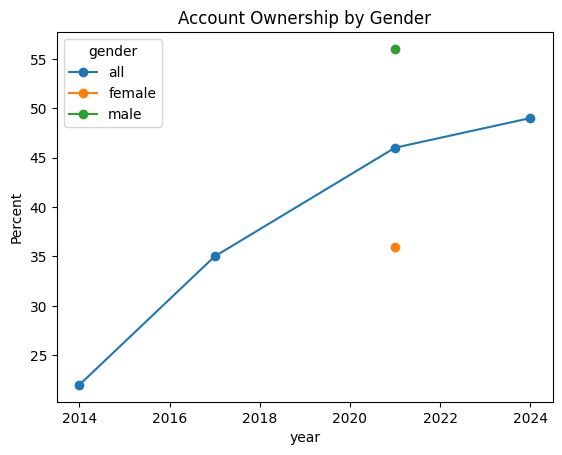

In [21]:
gender_data = account_ownership.dropna(subset=["gender"])

gender_pivot = gender_data.pivot(
    index="year", columns="gender", values="value_numeric"
)

gender_pivot.plot(marker="o")
plt.title("Account Ownership by Gender")
plt.ylabel("Percent")
plt.show()


In [22]:
gender_pivot["gap_male_female"] = (
    gender_pivot.get("male", 0) - gender_pivot.get("female", 0)
)
gender_pivot["gap_male_female"]


year
2014.0     NaN
2017.0     NaN
2021.0    20.0
2024.0     NaN
Name: gap_male_female, dtype: float64

#### 7.2 Urban vs Rural

In [23]:
location_data = account_ownership.dropna(subset=["location"])

duplicates = location_data.duplicated(subset=["year", "location"], keep=False)
location_data[duplicates][["year", "location", "value_numeric"]]


,year,location,value_numeric
2,2021.0,national,46.0
3,2021.0,national,56.0
4,2021.0,national,36.0


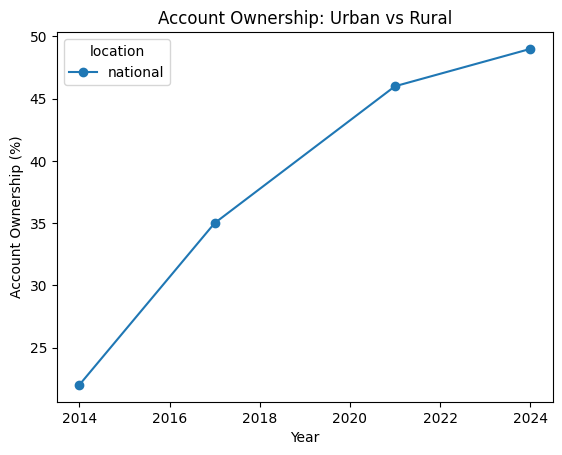

In [24]:

location_agg = location_data.groupby(["year", "location"])["value_numeric"].mean().reset_index()

location_pivot = location_agg.pivot(index="year", columns="location", values="value_numeric")


location_pivot.plot(marker="o")
plt.title("Account Ownership: Urban vs Rural")
plt.ylabel("Account Ownership (%)")
plt.xlabel("Year")
plt.show()


### 8. Investigate 2021–2024 Slowdown

In [25]:
account_ownership[
    account_ownership["year"].between(2021, 2024)
]


,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,...,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes,year,growth_pp
2,REC_0003,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.0,NaN,percentage,...,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN,2021.0,11.0
3,REC_0004,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,56.0,NaN,percentage,...,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN,2021.0,10.0
4,REC_0005,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,36.0,NaN,percentage,...,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN,2021.0,-20.0
5,REC_0006,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,49.0,NaN,percentage,...,NaN,NaN,NaN,Example_Trainee,2025-01-20,Account ownership increased from 46% to 49%,Survey Oct-Nov 2024,NaN,2024.0,13.0


### 9. Mobile Money Penetration Trend (2014–2024)

In [26]:
mobile_money = data[
    (data["indicator_code"] == "ACC_MM_ACCOUNT")
    & (data["record_type"] == "observation")  # observations, not "indicator"
].sort_values("year")


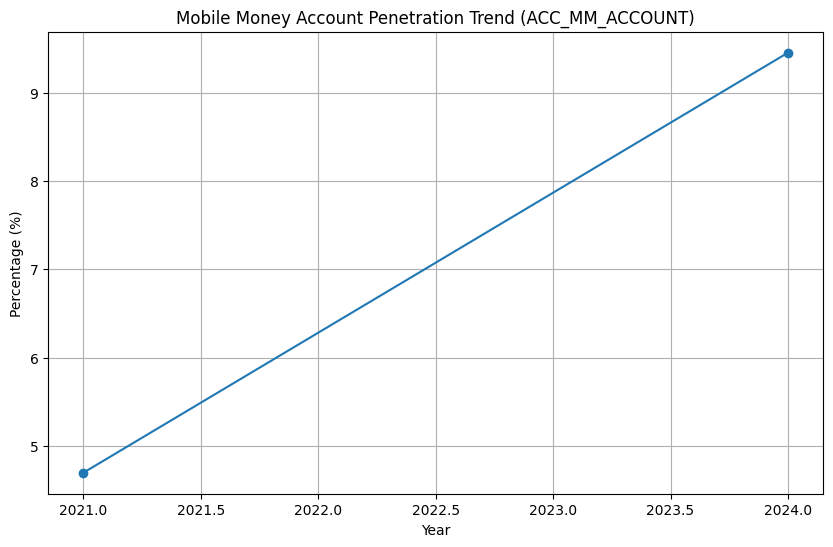

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(mobile_money["year"], mobile_money["value_numeric"], marker="o")
plt.title("Mobile Money Account Penetration Trend (ACC_MM_ACCOUNT)")
plt.xlabel("Year")
plt.ylabel("Percentage (%)")
plt.grid(True)
plt.show()

### 10. Digital Payment Adoption

In [28]:
digital_indicators = (
    data[["indicator", "indicator_code"]]
    .dropna()
    .drop_duplicates()
    .sort_values("indicator")
)

digital_indicators[
    digital_indicators["indicator"].str.contains(
        "mobile|money|payment|transaction|digital|telebirr|p2p",
        case=False,
        na=False
    )
]


,indicator,indicator_code
17,ATM Transaction Count,USG_ATM_COUNT
18,ATM Transaction Value,USG_ATM_VALUE
30,Active Mobile Money Accounts per 1000 Adults,USG_MM_ACTIVE_1K
40,Adults with National Digital ID,ACC_DIGITAL_ID_SHARE
59,EthioPay Instant Payment System Launch,EVT_ETHIOPAY
11,Fayda Digital ID Enrollment,ACC_FAYDA
55,Fayda Digital ID Program Rollout,EVT_FAYDA
28,Female Mobile Money Account Share,GEN_MM_SHARE
37,Merchants Accepting Digital Payments,USG_MERCHANT_ACCEPT
6,Mobile Money Account Rate,ACC_MM_ACCOUNT


In [29]:
adoption_codes = [
    "USG_ACTIVE_RATE",
    "USG_P2P_COUNT",
    "USG_P2P_VALUE",
    "USG_TELEBIRR_VALUE",
    "USG_CROSSOVER"
]

adoption = data[
    (data["record_type"] == "observation") &
    (data["indicator_code"].isin(adoption_codes))
]

adoption_agg = (
    adoption
    .groupby(["indicator_code", "year"], as_index=False)
    .agg({"value_numeric": "mean"})
)


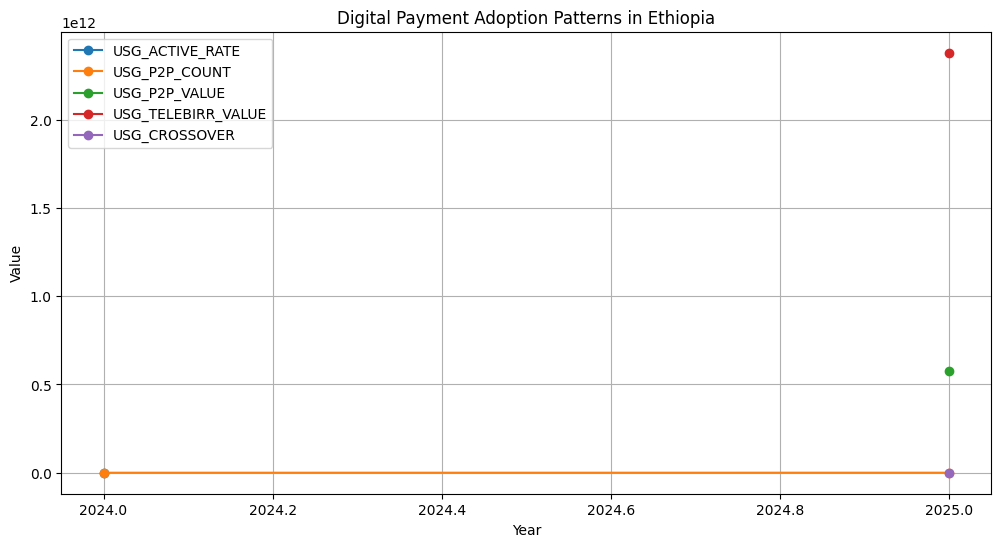

In [30]:
plt.figure(figsize=(12,6))

for code in adoption_codes:
    subset = adoption_agg[adoption_agg["indicator_code"] == code]
    plt.plot(subset["year"], subset["value_numeric"], marker="o", label=code)

plt.title("Digital Payment Adoption Patterns in Ethiopia")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


#### 10.1 Registered vs Active gap

In [31]:
gap_codes = ["ACC_MM_ACCOUNT", "USG_ACTIVE_RATE"]

gap = data[
    (data["record_type"] == "observation") &
    (data["indicator_code"].isin(gap_codes))
]

gap_agg = (
    gap.groupby(["indicator_code", "year"], as_index=False)
       .agg({"value_numeric": "mean"})
)


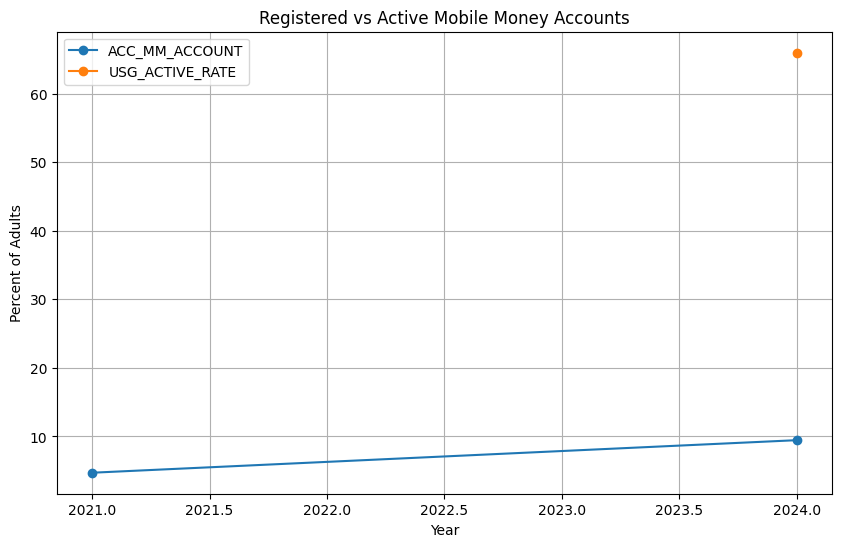

In [32]:
plt.figure(figsize=(10,6))

for code in gap_codes:
    subset = gap_agg[gap_agg["indicator_code"] == code]
    plt.plot(subset["year"], subset["value_numeric"], marker="o", label=code)

plt.title("Registered vs Active Mobile Money Accounts")
plt.xlabel("Year")
plt.ylabel("Percent of Adults")
plt.legend()
plt.grid(True)
plt.show()


#### 10.2 Payment use cases

In [33]:
p2p = adoption_agg[adoption_agg["indicator_code"].isin([
    "USG_P2P_COUNT",
    "USG_P2P_VALUE"
])]

p2p


,indicator_code,year,value_numeric
2,USG_P2P_COUNT,2024.0,4.970000e+07
3,USG_P2P_COUNT,2025.0,1.283000e+08
4,USG_P2P_VALUE,2025.0,5.777000e+11


### 12. Infrastructure Indicators

In [34]:
infra = data[
    data["indicator_code"].isin([
        "ACC_MOBILE_PEN",
        "ACC_4G_COV",
        "USG_ATM_COUNT",
        "USG_ATM_VALUE"
    ])
]


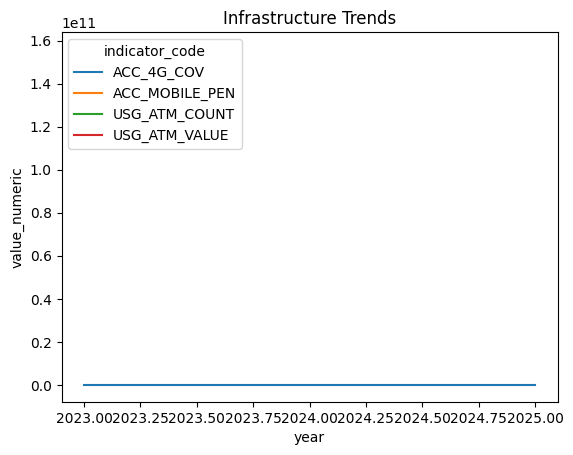

In [35]:
sns.lineplot(
    data=infra,
    x="year",
    y="value_numeric",
    hue="indicator_code"
)
plt.title("Infrastructure Trends")
plt.show()


### 13. Relationship with Inclusion Outcomes

In [36]:
merged = account_ownership.merge(
    infra, on="year", suffixes=("_access", "_infra")
)

merged[["value_numeric_access", "value_numeric_infra"]].corr()


,value_numeric_access,value_numeric_infra
value_numeric_access,NaN,NaN
value_numeric_infra,NaN,NaN


### 14. Event Timeline

In [37]:
events = data[data["record_type"].isin(["policy", "product_launch", "event"])]

events["event_year"] = pd.to_datetime(
    events["period_start"], errors="coerce"
).dt.year


/var/folders/7h/pt6smvdj6k993z68shptnrdc0000gn/T/ipykernel_8182/2839036964.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events["event_year"] = pd.to_datetime(


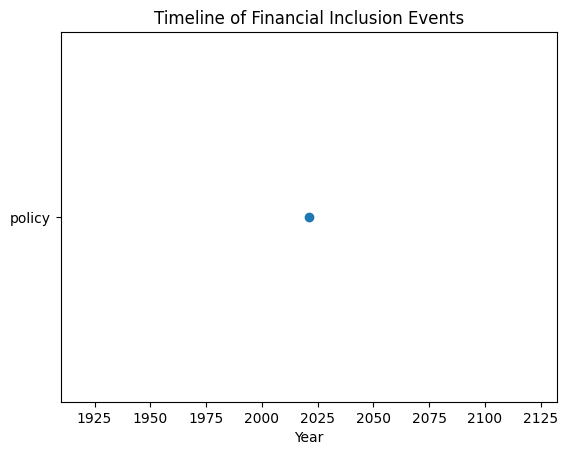

In [38]:
plt.scatter(events["event_year"], events["category"])
plt.title("Timeline of Financial Inclusion Events")
plt.xlabel("Year")
plt.show()


### 15. Overlay Events on Account Ownership

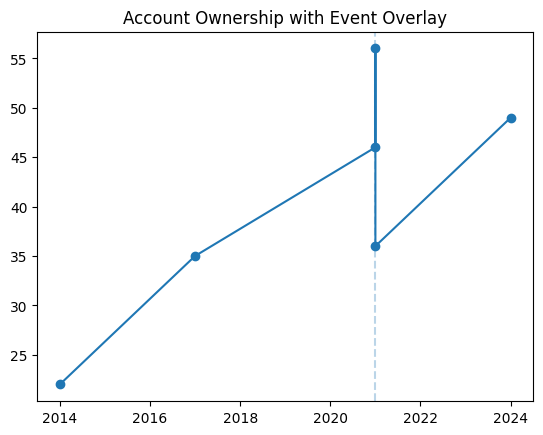

In [39]:
plt.plot(account_ownership["year"], account_ownership["value_numeric"], marker="o")

for _, row in events.iterrows():
    plt.axvline(row["event_year"], linestyle="--", alpha=0.3)

plt.title("Account Ownership with Event Overlay")
plt.show()


### 16. Indicator Correlation Matrix

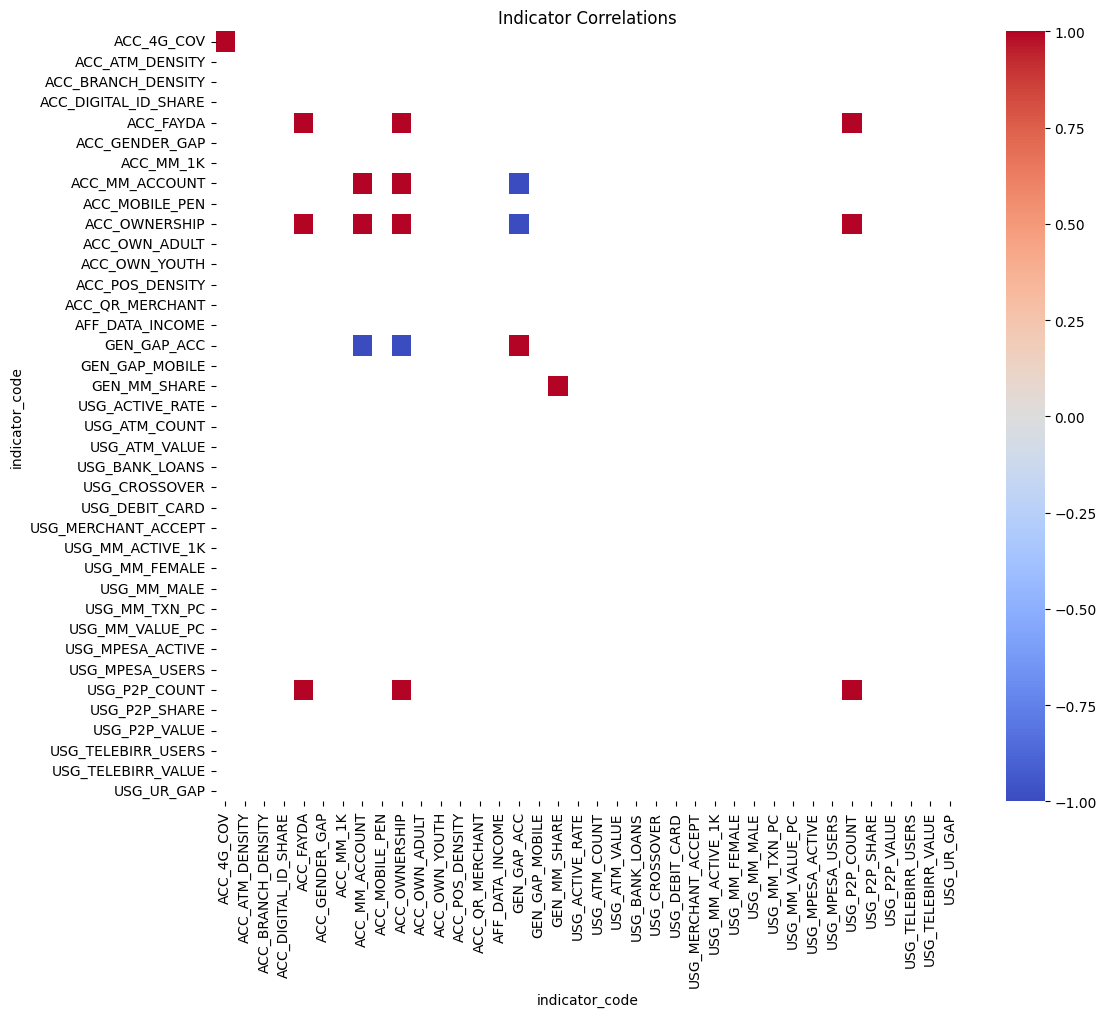

In [40]:
pivot = data.pivot_table(
    index="year",
    columns="indicator_code",
    values="value_numeric"
)

corr = pivot.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Indicator Correlations")
plt.show()


### Summary of Key Insights

##### 1. Financial inclusion growth has slowed despite rapid mobile money expansion

** Evidence:

- Account ownership increased from 46% (2021) to 49% (2024) — a net gain of +3 percentage points.

- This deceleration contrasts sharply with explosive growth in mobile money activity, such as P2P transaction counts rising from ~49.7M (2024) to ~128.3M (2025).

** Interpretation:
Mobile money growth is being driven primarily by existing account holders increasing usage, rather than by large numbers of new adults entering the formal financial system. This suggests inclusion constraints beyond simple availability of mobile money services.

##### 2. Usage indicators are far more developed than Access indicators

**Evidence:

- Dataset composition shows USAGE (21 indicators) nearly matching ACCESS (25 indicators) in count.

- Operator and survey data dominate sources, with operator-based usage data (20 records) being the single largest source type.

**Interpretation:
Ethiopia’s digital finance ecosystem appears to be usage-deepening before access-widening. This pattern is typical of early-to-mid stage DFS markets where infrastructure and regulatory changes stimulate transaction volume faster than new account adoption.

##### 3. Data coverage is highly uneven, limiting trend analysis

**Evidence:

- Over 30 indicators have data for only one year, and many others for just two years.

- Key indicators such as USG_MM_FEMALE, USG_MM_MALE, USG_UR_GAP, ACC_DIGITAL_ID_SHARE, and ACC_QR_MERCHANT appear only once.

** Interpretation:
Sparse temporal coverage prevents robust time-series analysis and weakens statistical inference (e.g., correlations returning NaN). This significantly constrains the ability to attribute changes in inclusion outcomes to specific policies or events.

##### 4. Gender disparities remain substantial and persistent

** Evidence:

- In 2021, the gender gap in account ownership reached 20 percentage points (male minus female).

- Gender-disaggregated usage indicators exist but are single-year observations, limiting trend analysis.

** Interpretation:
The persistence of a large gender gap suggests that mobile money availability alone does not resolve structural barriers (e.g., ID access, phone ownership, digital literacy). This reinforces the relevance of gender-focused enablers such as digital ID (Fayda).

##### 5. Infrastructure availability does not yet translate cleanly into inclusion outcomes

** Evidence:

- Infrastructure indicators (4G coverage, ATM density, branch density) exist but are mostly single-year observations.

- Correlation analysis between infrastructure indicators and account ownership returns NaN, due to insufficient overlapping time points.

** Interpretation:
While infrastructure expansion is necessary, your data suggests it is not sufficient on its own to explain inclusion outcomes. Complementary factors—policy, interoperability, trust, and affordability—likely play a critical role.

##### 6. Event timing aligns more clearly with usage growth than access growth

** Evidence:

- Major events (Telebirr launch in 2021, interoperability mandate in 2023, M-Pesa launch in 2023) coincide with strong growth in usage indicators (P2P counts, transaction values).

- No comparable acceleration is observed in account ownership after these events.

** Interpretation:
Policy and market-entry shocks appear to intensify how people use digital finance, rather than expanding who is included. This supports the hypothesis that Ethiopia’s binding constraints are now on onboarding and eligibility, not transaction rails.

##### 7. Data quality is generally high but unevenly documented

** Evidence:

- High-confidence records dominate (45 of 66), especially for survey-based indicators.

- However, 8 records lack confidence ratings, and some calculated indicators lack clear primary sources.

** Interpretation:
Overall data reliability is strong, but incomplete metadata reduces transparency. Improving documentation consistency (especially for calculated indicators) would strengthen future modeling and reproducibility.

##### 8. Leading indicators for future inclusion may lie in enablers rather than outcomes

** Evidence:

- Early-stage enablers such as digital ID coverage (ACC_DIGITAL_ID_SHARE) and QR merchant density are present but under-observed.

- Impact_link records hypothesize strong effects from these enablers on access and gender gaps.

**  Interpretation:
Future gains in financial inclusion are likely to be driven by foundational systems (ID, interoperability, merchant acceptance) rather than by further expansion of basic mobile money products.